**In this notebook, I have tested various Machine Learning models to predict the product category.**

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,  confusion_matrix
from sklearn.linear_model import SGDClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Loading the cleaned version of the original dataset. This dataset can be found  [here](https://drive.google.com/file/d/1uM5Kr_CieByJkZiSxVeKPhSpWV-aUYTY/view?usp=sharing).

In [4]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/flipkart_ecommerce_processed_sample.csv', index_col = 0)


print("The data shape is:", df.shape) # shape of the dataset
df.head()

The data shape is: (19287, 4)


,product_name,brand,description,label
0,U. R. GOD Business / Visiting 10 Card Holder,U. R. GOD,key features of u r god business visiting 10 ...,"Bags, Wallets & Belts"
1,Dong Yang 880 Pouch Soccer Art Cloth Pencil Box,NaN,flipkart com buy dong yang 880 pouch soccer ar...,Toys & School Supplies
2,Shreya Collection 3 Multicolour Hair Clips Ban...,Shreya Collection,key features of shreya collection 3 multicolou...,Beauty and Personal Care
3,Jewel Paradise Brass Plated Brass Necklace,Jewel Paradise,jewel paradise brass plated brass necklace bu...,Jewellery
4,Disney Princess Cartoon Art Plastic Pencil Box,NaN,flipkart com buy disney princess cartoon art p...,Toys & School Supplies


Let's take a look at the different categories in the dataset.

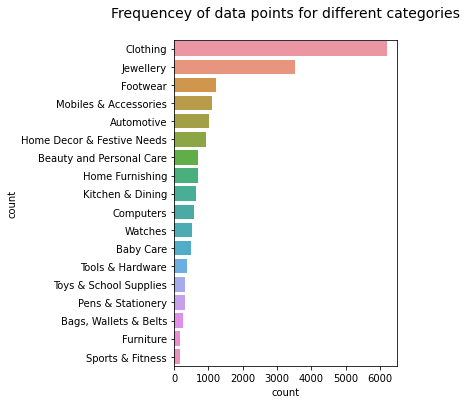


Total number of categories in the dataset -  18


In [5]:
value_counts = df.label.value_counts() # distinct categories in the dataset

all_categories = value_counts.to_frame('count')
all_categories['label'] = all_categories.index
all_categories = all_categories.reset_index(drop = True)

g = all_categories.nlargest(columns="count", n = 50) 
plt.figure(figsize=(4,6)) 
ax = sns.barplot(data=g, x= "count", y = "label") 
ax.set(ylabel = 'count') 
plt.title('Frequencey of data points for different categories\n', fontsize=14)
plt.show()

print("\nTotal number of categories in the dataset - ",len(value_counts)) # number of disctinct categories

Cleaning the data -

Visualising the frequency of the words in the dataset.

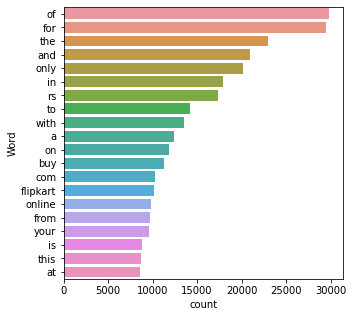

In [6]:
def words_frequency():
  """ This function visualizes the words and their frequency in the dataset """

  all_text = ' '.join([text for text in df['description']])
  words = all_text.split()

  frequency = Counter(words)

  frequency_df = pd.DataFrame({'word':list(frequency.keys()), 
                               'count':list(frequency.values())})
    
  # selecting top 20 most frequent words 
  d = frequency_df.nlargest(columns="count", n = 20) 
  
  # visualize words and frequencies
  plt.figure(figsize=(5,5)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()

words_frequency() 

It can be observed that the most frequent words in the dataset are stop words like of, for, the, etc. These words carry less meaning and just add noise to our data, so we will remove the stop words from the data.

In [7]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) # stop words in english

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

df['description'] = df['description'].apply(lambda x: remove_stopwords(x)) # product description without stop words

Visualising the frequency of words in the dataset after the removal of stop words.

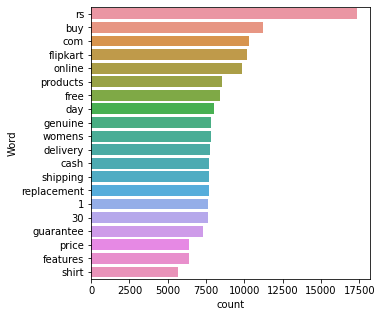

In [8]:
words_frequency()

It can be observed that the most frequent words are far more meaningful that before.

Frequency of data points for a given length -

Average length of a product description -  52.045108103904184 




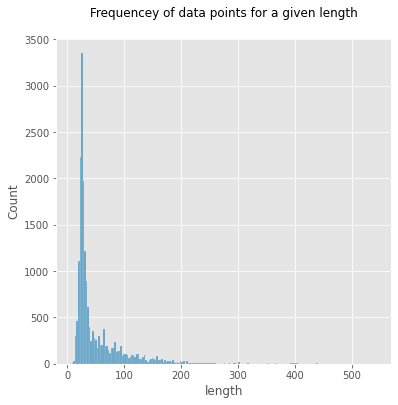

In [9]:
plt.style.use("ggplot")

plt.figure(figsize=(6, 6))
df['length'] = df['description'].apply(lambda x: len(x.split()))
sns.histplot(df['length'])

plt.title('Frequencey of data points for a given length\n', fontsize=12)
plt.xlabel('length', fontsize=12)
None

print("Average length of a product description - ", df.length.mean(), "\n\n")

Encoding The Labels 

In [10]:
possible_labels = df.label.unique() # unique labels/categories in the dataset

label_dict = {}
for index, possible_label in enumerate(possible_labels): # creating a dictionary, label : encoded_value
    label_dict[possible_label] = index

print(label_dict)

df['labels'] = df['label'].map(label_dict) # encoding each unique label according to label_dict

{'Bags, Wallets & Belts': 0, 'Toys & School Supplies': 1, 'Beauty and Personal Care': 2, 'Jewellery': 3, 'Baby Care': 4, 'Clothing': 5, 'Mobiles & Accessories': 6, 'Automotive': 7, 'Footwear': 8, 'Pens & Stationery': 9, 'Watches': 10, 'Home Furnishing': 11, 'Sports & Fitness': 12, 'Home Decor & Festive Needs': 13, 'Tools & Hardware': 14, 'Computers': 15, 'Kitchen & Dining': 16, 'Furniture': 17}


In [11]:
df.head()

,product_name,brand,description,label,length,labels
0,U. R. GOD Business / Visiting 10 Card Holder,U. R. GOD,key features u r god business visiting 10 card...,"Bags, Wallets & Belts",117,0
1,Dong Yang 880 Pouch Soccer Art Cloth Pencil Box,NaN,flipkart com buy dong yang 880 pouch soccer ar...,Toys & School Supplies,26,1
2,Shreya Collection 3 Multicolour Hair Clips Ban...,Shreya Collection,key features shreya collection 3 multicolour h...,Beauty and Personal Care,96,2
3,Jewel Paradise Brass Plated Brass Necklace,Jewel Paradise,jewel paradise brass plated brass necklace buy...,Jewellery,27,3
4,Disney Princess Cartoon Art Plastic Pencil Box,NaN,flipkart com buy disney princess cartoon art p...,Toys & School Supplies,24,1


Initializing the Vectorizer - [reference link](https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/)

In [12]:
tfidf = TfidfVectorizer()

Spiltting the dataset into train and test sets.

train_set -> 70%, 
test_set -> 30%

In [13]:
train_x, test_x, train_y, test_y = train_test_split(df['description'], df['labels'], test_size=0.3, random_state=9)

Creating features for the train and test set.

In [14]:
train_features = tfidf.fit_transform(train_x)
test_features = tfidf.transform(test_x)

**Now, we will try different ML models on the data and observe how well they fit on our data.**

Reference used - [Dealing with Imbalanced Data](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)

In [21]:
def display_confusion_matrix(y, y_pred):
  """To print the confusion matrix"""

  cm = confusion_matrix(y, y_pred)
  plt.figure(figsize=(8, 8))
  ax = plt.subplot()

  sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

  ax.set_title('Confusion Matrix')

  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')

**1. Naive Bayes** ([MutinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html))

              precision    recall  f1-score   support

           0       0.80      0.06      0.10        72
           1       1.00      0.05      0.10       119
           2       0.99      0.52      0.68       220
           3       0.68      0.99      0.81      1043
           4       1.00      0.35      0.51       150
           5       0.82      1.00      0.90      1855
           6       0.92      0.94      0.93       318
           7       0.95      0.94      0.94       301
           8       1.00      0.81      0.89       363
           9       1.00      0.23      0.37        93
          10       1.00      0.84      0.91       166
          11       0.92      0.67      0.78       206
          12       0.00      0.00      0.00        52
          13       0.94      0.88      0.91       259
          14       1.00      0.73      0.84       125
          15       1.00      0.69      0.82       166
          16       0.98      0.68      0.80       217
          17       1.00    

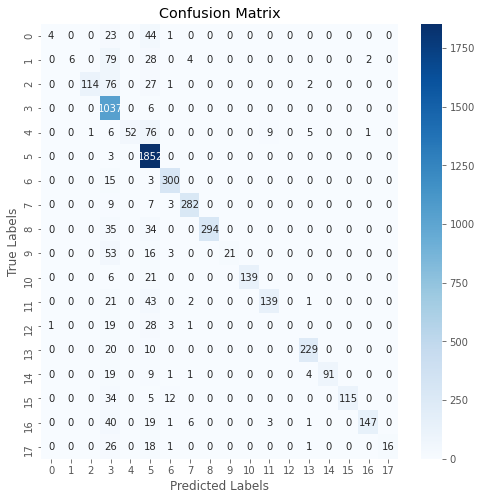

In [28]:
naive_bayes = MultinomialNB() # Initialize the MultinomialNB classifier
naive_bayes.fit(train_features, train_y) # Train the classifier
predictions = naive_bayes.predict(test_features) # Test the classifier

print(classification_report(test_y, predictions), "\n\n") # print metrics
display_confusion_matrix(test_y, predictions) # display confusion matrix

**2. Random Forest Classifier** ([RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        72
           1       0.83      0.87      0.85       119
           2       0.79      0.85      0.82       220
           3       0.98      0.98      0.98      1043
           4       0.72      0.80      0.76       150
           5       0.99      0.97      0.98      1855
           6       0.98      0.91      0.94       318
           7       0.97      0.95      0.96       301
           8       0.96      0.96      0.96       363
           9       0.86      0.65      0.74        93
          10       0.99      0.98      0.98       166
          11       0.87      0.96      0.91       206
          12       0.48      0.71      0.57        52
          13       0.89      0.92      0.90       259
          14       0.61      0.90      0.73       125
          15       0.89      0.89      0.89       166
          16       0.96      0.75      0.84       217
          17       0.95    

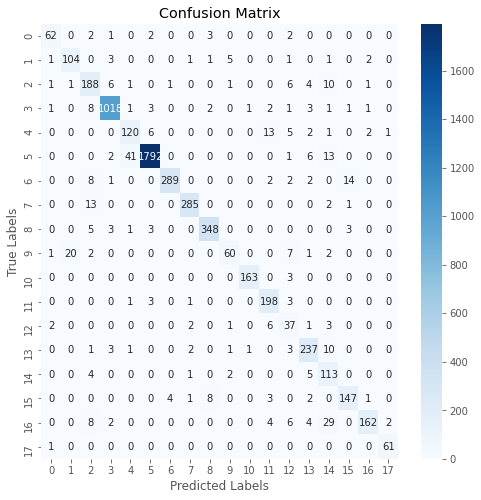

In [29]:
rf = RandomForestClassifier(n_estimators = 128, max_depth = 16, max_features = 100, class_weight= 'balanced') # Initializing the classifier
rf.fit(train_features, train_y) # training the classifier
predictions = rf.predict(test_features) # testing the classifier
print(classification_report(test_y, predictions)) # print metrics
display_confusion_matrix(test_y, predictions) # display confusion matrix

**3. XGBoost - It is a version of gradient boosted decision tree classifier.** ([Reference](https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        72
           1       0.86      0.74      0.80       119
           2       0.98      0.94      0.96       220
           3       0.98      0.99      0.99      1043
           4       0.90      0.89      0.90       150
           5       0.98      0.99      0.99      1855
           6       0.96      0.97      0.97       318
           7       0.98      0.99      0.98       301
           8       0.98      0.97      0.98       363
           9       0.72      0.72      0.72        93
          10       1.00      0.98      0.99       166
          11       0.93      0.98      0.95       206
          12       0.93      0.71      0.80        52
          13       0.93      0.96      0.94       259
          14       0.97      0.94      0.96       125
          15       0.93      0.90      0.91       166
          16       0.92      0.93      0.92       217
          17       0.97    

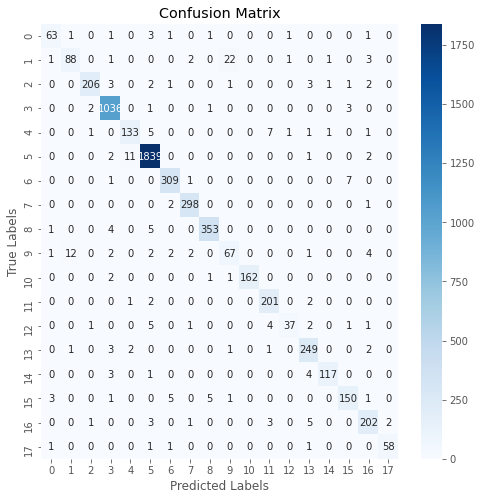

In [31]:
model = XGBClassifier() # Initializing the classifier
model.fit(train_features, train_y) # Training the classifier
predictions = model.predict(test_features) # Testing the classifier
print(classification_report(test_y, predictions)) # print metrics
display_confusion_matrix(test_y, predictions) # display confusion matrix

**4.  SVM with SGD training** ([SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        72
           1       0.86      0.90      0.88       119
           2       0.98      0.97      0.97       220
           3       1.00      1.00      1.00      1043
           4       0.91      0.84      0.87       150
           5       0.99      0.99      0.99      1855
           6       0.95      0.99      0.97       318
           7       0.98      0.99      0.98       301
           8       1.00      0.99      1.00       363
           9       0.85      0.74      0.79        93
          10       1.00      0.99      0.99       166
          11       0.93      1.00      0.96       206
          12       0.90      0.88      0.89        52
          13       0.96      0.99      0.98       259
          14       1.00      0.94      0.97       125
          15       0.99      0.95      0.97       166
          16       0.96      0.95      0.95       217
          17       0.97    

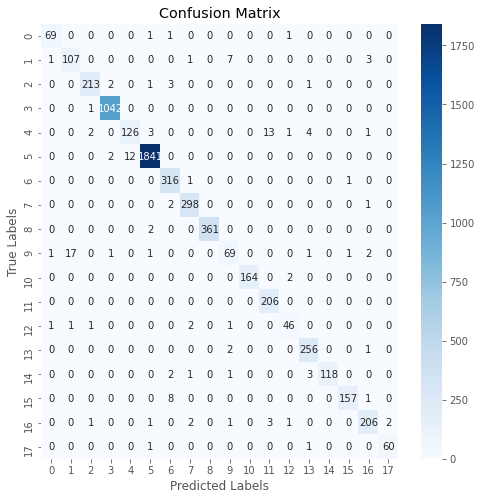

In [33]:
sgd = SGDClassifier() # initialize the classifier
sgd.fit(train_features, train_y) # train the classifier
predictions = sgd.predict(test_features) # test the classifier
print(classification_report(test_y, predictions)) # print metrics
display_confusion_matrix(test_y, predictions) # display confusion matrix